<a href="https://colab.research.google.com/github/dataforgoodfr/batch7_satellite_ges/blob/master/notebooks/04_15_OCO2_Laiwu_Peak_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

In [0]:
!pip install lmfit

# OCO2 - Reproduce F. Chevallier's figures

Project for **Data For Good**, season 7. 

*By Quentin Kamenda, Benoit Courty, Charlotte Degot*


---

## Introduction

Using Data from [OCO-2 Satellite](en.wikipedia.org/wiki/Orbiting_Carbon_Observatory_2), issued by the NASA.

We here try to reproduce the results from [this paper](https://www.atmos-chem-phys-discuss.net/acp-2020-123/) by F. Chevallier, trying to "[observe] carbon dioxide emissions over China's cities with the Orbiting Carbon Observatory-2".

`//TODO: Explanation`

In [0]:
import pandas as pd
import numpy as np
from numpy import exp, loadtxt, pi, sqrt
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.optimize import curve_fit
from mpl_toolkits.basemap import Basemap  #Imported directly from the github repository

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Show Data on the map

##### **draw_map**: Function to draw the map and the observations (relief style). The column names can be specified in the arguments.

*Parameters*: 

*   (DataFrame) data: the dataset to map.
*   (string) **x** : the name of the longitude column. *default: 'longitide'*
*   (string) **y**: the name of the latitude column. *default: 'latitude'*
*   (string) **c**: the name of the XCO2 column (or other measure wanted to be plotted). *default: 'xco2'*
*   (int) **lon_min** : the minimum longitude. *default: -180*
*   (int) **lon_max**: the maximum longitude. *default: 180*
*   (int) **lat_min**: the minimum latitude. *default: -90*
*   (int) **lat_max**: the maximum latitude. *default: 90*
*   (int) **size_point**: size of the point to plot (useful if we zoom in). *default: 1*
*   (Bool) **frontier**: whether or not to draw the countries borders. *default: False*



In [0]:
def draw_map(data, x="longitude", y="latitude", c="xco2", lon_min=-180, lon_max=180, lat_min=-90, lat_max=90, size_point=1, frontier=False):

    plt.figure(figsize=(15, 10), edgecolor='w')
    m = Basemap(llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max)
    
    m.shadedrelief()
    
    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,labels=[False,True,True,False])

    meridians = np.arange(10.,351.,20.)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    normal = matplotlib.colors.LogNorm(vmin=data[c].min(), vmax=data[c].max())

    m.scatter(data[x], data[y], c=data[c], cmap=plt.cm.jet, s=size_point, norm=normal)

    if (frontier):
      m.drawcountries(linewidth=0.5)
      m.drawcoastlines(linewidth=0.7)

    plt.show()

##### **haversine**: Function to calculate the great circle distance between two points on the earth given longitude and latitude.

*Parameters*: 

*   (int) **lon1** : the longitude of the first point.
*   (int) **lon2**: the latitude of the first point.
*   (int) **lat1**: the longitude of the second point.
*   (int) **lat2**: the latitude of the second point.

*Return:*


*   (int) the distance (in kilometers)

In [0]:
from math import radians, cos, sin, asin, sqrt, atan2, degrees

# calculate distance between two peaks
def haversine_formula(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# calculate new coordinates of a point
def haversine_reverse(lat1,lon1,bearing,d):
    R = 6371                     #Radius of the Earth
    lon1, lat1, brng = map(radians, [lon1, lat1, bearing])
    d = d*1.852                  #convert nautical miles to km

    lat2 = asin( sin(lat1)*cos(d/R) + cos(lat1)*sin(d/R)*cos(brng))
    lon2 = lon1 + atan2(sin(brng)*sin(d/R)*cos(lat1),cos(d/R)-sin(lat1)*sin(lat2))
    lat2 = degrees(lat2)
    lon2 = degrees(lon2)
    return lat2,lon2

def haversine(row, lat, lon):
    return haversine_formula(lon, lat, row['longitude'], row['latitude'])

In [0]:
print(haversine_reverse(45, 45, 0, 1500))
print(haversine_reverse(45, 45, 90, 1500))

(69.98315421242232, 45.0)
(39.862263432766966, 78.3829834854349)


---
---

## Retieve Data

Sample data can be accessed freely on the NASA Database, among other open data from several NASA sattelites.

We will be using CSV aggregated by *Benoit Courty* [here](https://http://benemie.fr/OCO2/).

In [0]:
data_1808 = pd.read_csv("http://benemie.fr/OCO2/oco2_1808.csv", sep=";")

data_1808.head()

sounding_id   latitude   longitude  ...  orbit  windspeed_u  windspeed_v
0  2018080100462105 -33.015541 -164.508881  ...  21709     3.749916     9.128431
1  2018080100462137 -32.988529 -164.553787  ...  21709     3.720200     9.087859
2  2018080100462171 -32.996235 -164.435699  ...  21709     3.815527     9.151507
3  2018080100462172 -32.992409 -164.455872  ...  21709     3.799832     9.138914
4  2018080100462173 -32.988403 -164.476196  ...  21709     3.783962     9.126184

[5 rows x 8 columns]

In [0]:
data_1808.describe()

sounding_id      latitude  ...   windspeed_u   windspeed_v
count  2.709745e+06  2.709745e+06  ...  2.709745e+06  2.709745e+06
mean   2.018082e+15  9.176796e+00  ... -1.533030e+00  2.852832e-01
std    9.141199e+08  2.900338e+01  ...  4.292128e+00  3.490388e+00
min    2.018080e+15 -5.199191e+01  ... -1.231609e+01 -1.428720e+01
25%    2.018081e+15 -1.714714e+01  ... -4.930158e+00 -2.060896e+00
50%    2.018082e+15  4.388992e+00  ... -2.304201e+00  3.646293e-01
75%    2.018082e+15  3.448813e+01  ...  1.599859e+00  2.797290e+00
max    2.018083e+15  8.186122e+01  ...  1.637950e+01  1.493328e+01

[8 rows x 8 columns]

To convert the  ``` sounding_id ``` into a datetime variable ```data```:



In [0]:
from datetime import datetime
def to_date(a):
    return datetime.strptime(str(a), '%Y%m%d%H%M%S%f')

data_1808['date'] = data_1808['sounding_id'].apply(to_date)

In [0]:
data_1808.head()

sounding_id   latitude  ...  windspeed_v                    date
0  2018080100462105 -33.015541  ...     9.128431 2018-08-01 00:46:21.050
1  2018080100462137 -32.988529  ...     9.087859 2018-08-01 00:46:21.370
2  2018080100462171 -32.996235  ...     9.151507 2018-08-01 00:46:21.710
3  2018080100462172 -32.992409  ...     9.138914 2018-08-01 00:46:21.720
4  2018080100462173 -32.988403  ...     9.126184 2018-08-01 00:46:21.730

[5 rows x 9 columns]

We are seaking the emission peak taken as an example in the annexes of F. Chevallier's article **Observing carbon dioxide emissions over China's cities with the Orbiting Carbon Observatory-2**:

*   Over Laiwu, the 25th August 2018



---

## Graphs A-B : Plotted orbit and Zoomed in over Laiwu

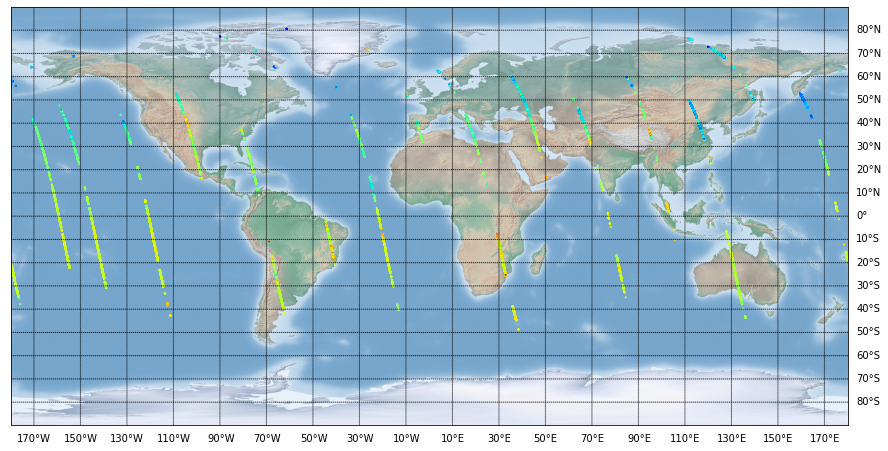

In [0]:
# We consider the August 2018 datset at the right day
data_1808_25 = data_1808[data_1808['date'] < "2018-08-26"]
data_1808_25 = data_1808_25[data_1808_25['date'] > "2018-08-25"]

draw_map(data_1808_25)

In [0]:
# We consider the orbit going over East China
#data_laiwu = data_1808_25[data_1808_25['longitude'] > 110]
#data_laiwu = data_laiwu[data_laiwu['longitude'] < 125]

data_laiwu = data_1808_25[data_1808_25['orbit'] == 22061]

data_laiwu

sounding_id   latitude  ...  windspeed_v                    date
2061319  2018082504501738 -43.749119  ...    -4.509858 2018-08-25 04:50:17.380
2061320  2018082504501777 -43.735889  ...    -4.486870 2018-08-25 04:50:17.770
2061321  2018082504501778 -43.731358  ...    -4.501010 2018-08-25 04:50:17.780
2061322  2018082504501806 -43.722591  ...    -4.463718 2018-08-25 04:50:18.060
2061323  2018082504501835 -43.709126  ...    -4.440311 2018-08-25 04:50:18.350
...                   ...        ...  ...          ...                     ...
2073115  2018082505183238  49.763687  ...     2.200201 2018-08-25 05:18:32.380
2073116  2018082505214175  59.688877  ...     0.018251 2018-08-25 05:21:41.750
2073117  2018082505214176  59.679939  ...     0.015300 2018-08-25 05:21:41.760
2073118  2018082505214207  59.687191  ...     0.013121 2018-08-25 05:21:42.070
2073119  2018082505214238  59.694370  ...     0.010925 2018-08-25 05:21:42.380

[11801 rows x 9 columns]

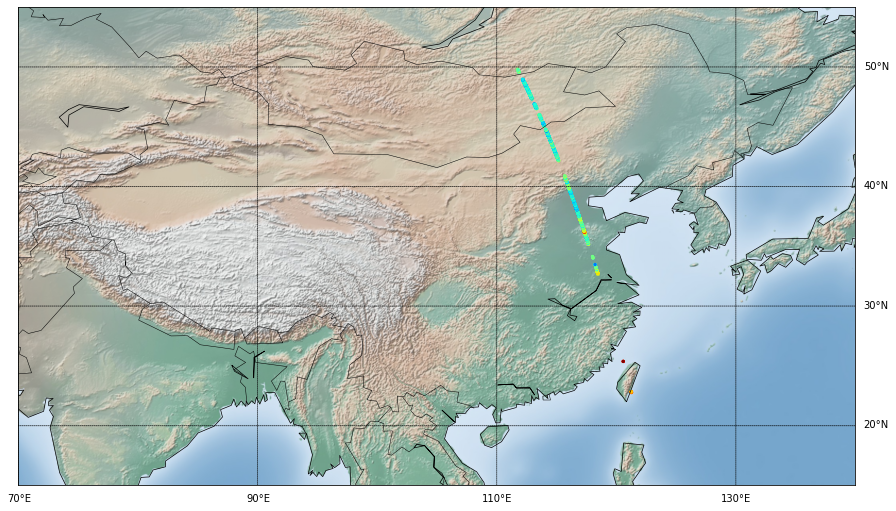

In [0]:
# We retrieve the Figure 2.A
draw_map(data_laiwu, lon_min=70, lon_max=140, lat_min=15, lat_max=55, frontier=True, size_point=5)

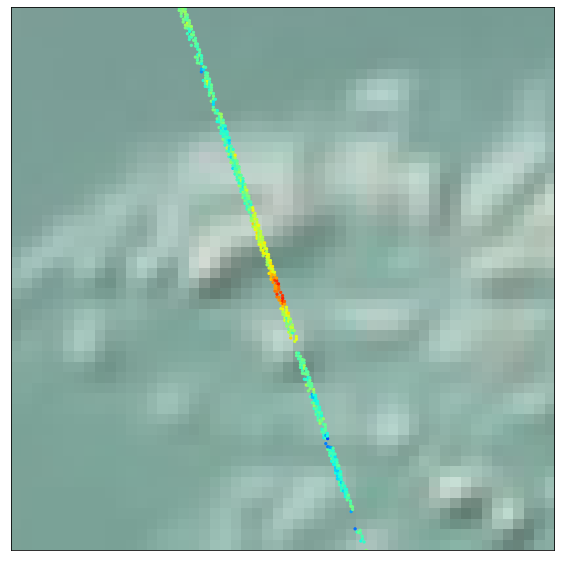

In [0]:
# We represent the observation zoomed on Anshan
draw_map(data_laiwu, lon_min=116.5, lon_max=118.2, lat_min=35.4, lat_max=37.1, frontier=True, size_point=5)

## Graph C: Valid XCO2 observations and fitted Gaussian curve

### Plotting XCO2 data poitns

In [0]:
# We restrict the data to the window studied
data_laiwu = data_laiwu.query('longitude>116.5 and longitude<118.2  and latitude>35.4 and latitude<37.1')

lon_min = data_laiwu['longitude'].iloc[0]
lat_min = data_laiwu['latitude'].iloc[0]

# We create a 'distance' column considering th distance of the measure to the minimal longitude and latitude
data_laiwu['distance'] = data_laiwu.apply(lambda row: haversine(row, lat_min, lon_min), axis=1)
data_laiwu

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


sounding_id   latitude  ...                    date    distance
2069837  2018082505140774  35.429119  ... 2018-08-25 05:14:07.740    0.000000
2069840  2018082505140802  35.467060  ... 2018-08-25 05:14:08.020    4.521399
2069841  2018082505140803  35.457211  ... 2018-08-25 05:14:08.030    3.308548
2069842  2018082505140835  35.455803  ... 2018-08-25 05:14:08.350    3.026735
2069843  2018082505140837  35.436092  ... 2018-08-25 05:14:08.370    0.884612
...                   ...        ...  ...                     ...         ...
2070385  2018082505143808  37.056301  ... 2018-08-25 05:14:38.080  187.215553
2070391  2018082505143836  37.094391  ... 2018-08-25 05:14:38.360  191.738508
2070392  2018082505143837  37.084496  ... 2018-08-25 05:14:38.370  190.532219
2070393  2018082505143838  37.074539  ... 2018-08-25 05:14:38.380  189.322151
2070400  2018082505143878  37.092781  ... 2018-08-25 05:14:38.780  191.428249

[548 rows x 10 columns]

In [0]:
data_laiwu = data_laiwu.sort_values(by=['distance']).reindex()
data_laiwu.head(7)

sounding_id   latitude  ...                    date  distance
2069837  2018082505140774  35.429119  ... 2018-08-25 05:14:07.740  0.000000
2069843  2018082505140837  35.436092  ... 2018-08-25 05:14:08.370  0.884612
2069844  2018082505140838  35.426098  ... 2018-08-25 05:14:08.380  0.978853
2069846  2018082505140878  35.444321  ... 2018-08-25 05:14:08.780  1.728416
2069845  2018082505140877  35.454258  ... 2018-08-25 05:14:08.770  2.798695
2069842  2018082505140835  35.455803  ... 2018-08-25 05:14:08.350  3.026735
2069841  2018082505140803  35.457211  ... 2018-08-25 05:14:08.030  3.308548

[7 rows x 10 columns]

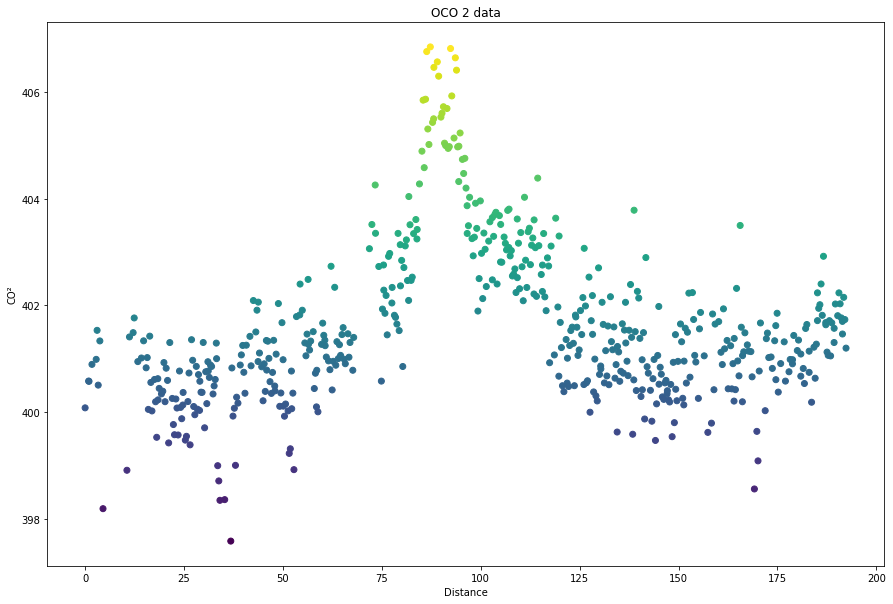

In [0]:
plt.figure(figsize=(15, 10), edgecolor='w')
plt.scatter(x=data_laiwu['distance'], y=data_laiwu['xco2'], c=data_laiwu['xco2'])
plt.title('OCO 2 data')
plt.xlabel('Distance')
plt.ylabel('CO²')
plt.show()

### Fitting the curve

In [0]:
df = data_laiwu
x = df['distance']
y = df['xco2']


# spatial window for the detection (km)
window = 200
good_find = 0
popt_saved, pcov_saved = [], []
soundings, sigmas = [], []
def func(x, m, b, A, sig):
    return m * x + b + A / (sig * (2 * np.pi)**0.5) * np.exp(-x**2 / (2*sig**2))


for i, j in enumerate(data_laiwu.index):
    try:
        # skip 19 observations 
        if(i%20 != 0): continue

        # calculate zero position
        med_temp = np.median(df['xco2'])
        std_temp = np.std(df['xco2'])
        df['xco2_enhancement'] = df['xco2'] - med_temp
        p0 = (0.,med_temp,30*df.loc[j,'xco2_enhancement'],10.)
        d_centered = df['distance'] - df.loc[j, 'distance']
      
        # try to fit the curve
        popt, pcov = curve_fit(func, d_centered, df['xco2'], sigma = df['xco2_uncert'], p0 = p0, maxfev=20000)

        # Filter the sigma
        sig = abs(popt[3])  # sigma of the Gaussian (km)
        if sig < 2 : continue  # too narrow
        if 3*sig > window / 2.: continue  # too large

        #
        delta = popt[2]/(popt[3]*(2 * np.pi)**0.5)  # height of the peak (ppm)
        if delta < 0: continue  # depletion
        d_plume = df[(d_centered >= -2*sig) & (d_centered <= 2*sig)]
        d_backg = df[(d_centered < -2*sig) | (d_centered > 2*sig)]
        d_peak = df[(d_centered >= -4*sig) & (d_centered <= 4*sig)]
        d_peak_distance = d_peak['distance'] - df.loc[j, 'distance']

        # we want at least 1 1-km-sounding per km on average on both sides of the peak within 2 sigmas and between 2 and 3 sigmas
        if len(df[(d_centered >= -1*sig) & (d_centered <= 0)]) < int(sig): continue
        if len(df[(d_centered <= 1*sig) & (d_centered >= 0)]) < int(sig): continue
        if len(df[(d_centered >= -3*sig) & (d_centered <= -2*sig)]) < int(sig): continue
        if len(df[(d_centered <= 3*sig) & (d_centered >= 2*sig)]) < int(sig): continue

        # check the quality of the fit
        R = np.corrcoef(func(d_peak_distance,*popt), d_peak['xco2'])
        if R[0,1]**2 < 0.25 : continue

        good_find += 1
        print('Good fit n°', good_find, ' -  Sigma:', round(sig,2), ' -  Ampleur:', round(delta,2), ' -  Coef de coreflation', round(R[0][1],2))
        soundings.append(j)
        sigmas.append(sig)
        popt_saved.append(popt)
        pcov_saved.append(pcov)

    except RuntimeError: 
      # curve_fit failed 
      print('LOST', j)

Good fit n° 1  -  Sigma: 22.48  -  Ampleur: 3.43  -  Coef de coreflation 0.7
Good fit n° 2  -  Sigma: 16.69  -  Ampleur: 3.81  -  Coef de coreflation 0.8
Good fit n° 3  -  Sigma: 14.26  -  Ampleur: 4.01  -  Coef de coreflation 0.83
Good fit n° 4  -  Sigma: 16.88  -  Ampleur: 3.55  -  Coef de coreflation 0.76
Good fit n° 5  -  Sigma: 21.54  -  Ampleur: 2.88  -  Coef de coreflation 0.64
LOST 2070327


Best m, b, A, sig =  [3.92312642e-03 4.00770662e+02 1.43464776e+02 1.42616933e+01]


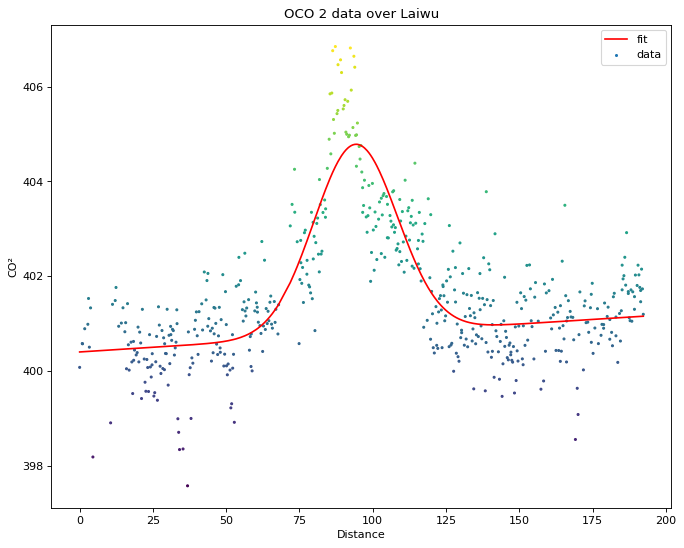

In [0]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

index=np.argmin(sigmas)
popt=popt_saved[index]
print('Best m, b, A, sig = ', popt)

plt.scatter(x, y, c=y, s=3, label='data')
plt.plot(x, func(x = x-data_laiwu.loc[soundings[index], 'distance'], m=popt[0], b=popt[1], A=popt[2], sig=popt[3]), 'r', label='fit')
plt.legend()
plt.title('OCO 2 data over Laiwu')
plt.xlabel('Distance')
plt.ylabel('CO²')
plt.show()

## Graph D: Enhanced data and fitted curve

Best m, b, A, sig =  [3.92312642e-03 4.00770662e+02 1.43464776e+02 1.42616933e+01]
Area under curve 2 : 143.51


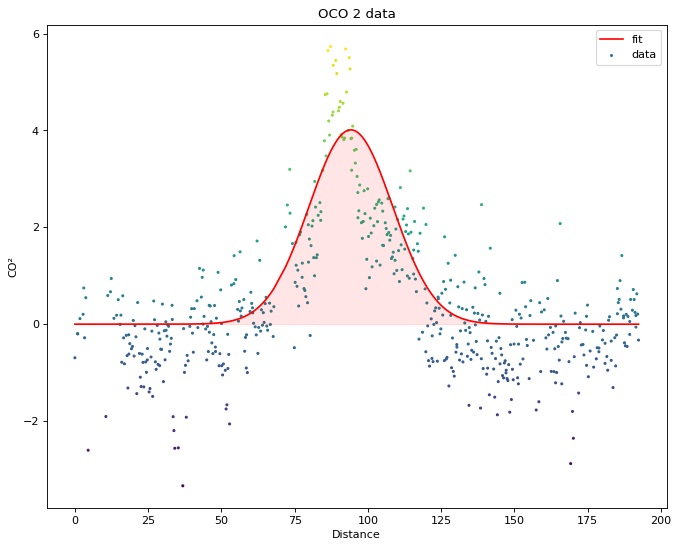

In [0]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

x = data_laiwu['distance']
y = data_laiwu['xco2']

index=np.argmin(sigmas)
popt=popt_saved[index]
print('Best m, b, A, sig = ', popt)
print("Area under curve", index, ":", round(np.trapz(func(x = x-data_laiwu.loc[soundings[index], 'distance'], m=0, b=0, A=popt[2], sig=popt[3]), x),2))
m,b,A,sig =popt[0], popt[1], popt[2], popt[3]

y = y - m * x - b
plt.scatter(x, y, c=y, s=3, label='data')
plt.plot(x, func(x = x-data_laiwu.loc[soundings[index], 'distance'], m=0, b=0, A=popt[2], sig=popt[3]), 'r', label='fit')

plt.fill_between(x, func(x = x-data_laiwu.loc[soundings[index], 'distance'], m=0, b=0, A=popt[2], sig=popt[3]), color=(1,0,0,0.1))

plt.legend()
plt.title('OCO 2 data')
plt.xlabel('Distance')
plt.ylabel('CO²')
plt.show()

Best m, b, A, sig =  [8.94418811e-03 4.00409566e+02 1.93366926e+02 2.24796188e+01]
Area under curve 0 : 193.32


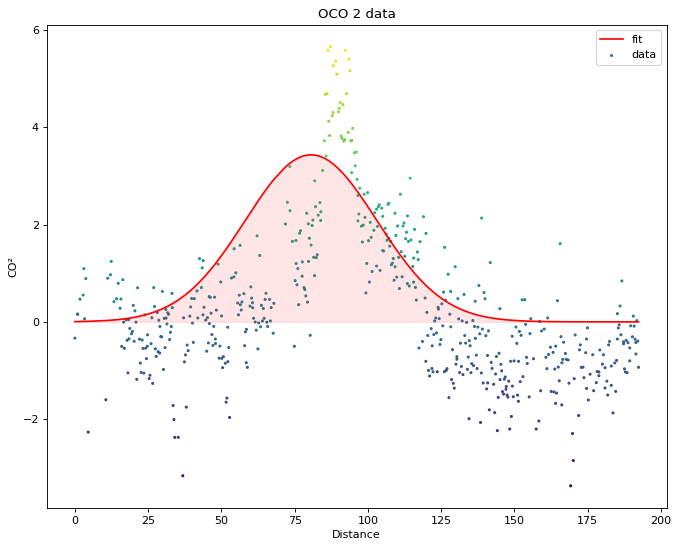

Best m, b, A, sig =  [5.98979760e-03 4.00665705e+02 1.59394915e+02 1.66933533e+01]
Area under curve 1 : 159.4


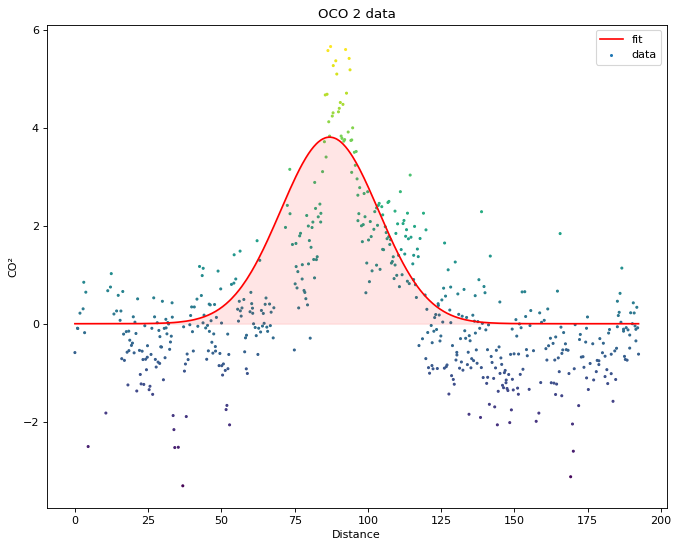

Best m, b, A, sig =  [3.92312642e-03 4.00770662e+02 1.43464776e+02 1.42616933e+01]
Area under curve 2 : 143.51


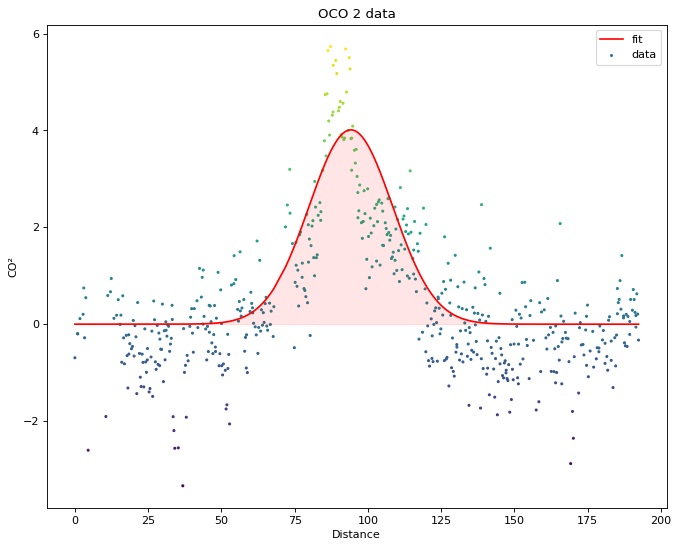

Best m, b, A, sig =  [2.11725401e-03 4.00746193e+02 1.50141204e+02 1.68797040e+01]
Area under curve 3 : 150.17


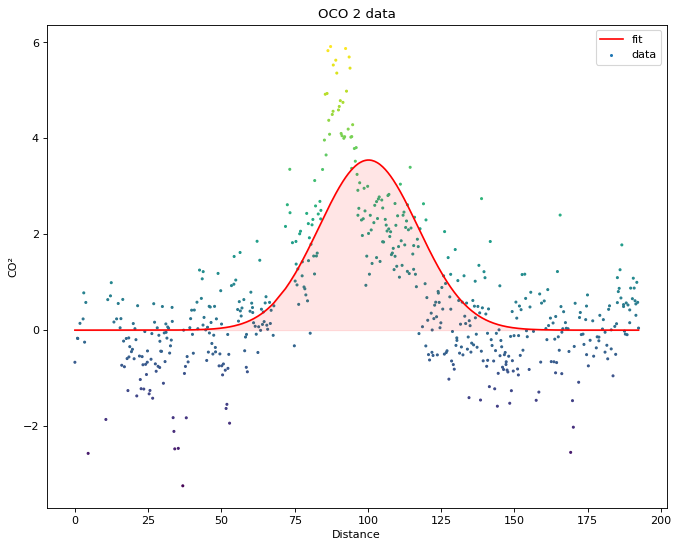

Best m, b, A, sig =  [-4.90156577e-04  4.00684657e+02  1.55282007e+02  2.15369685e+01]
Area under curve 4 : 155.29


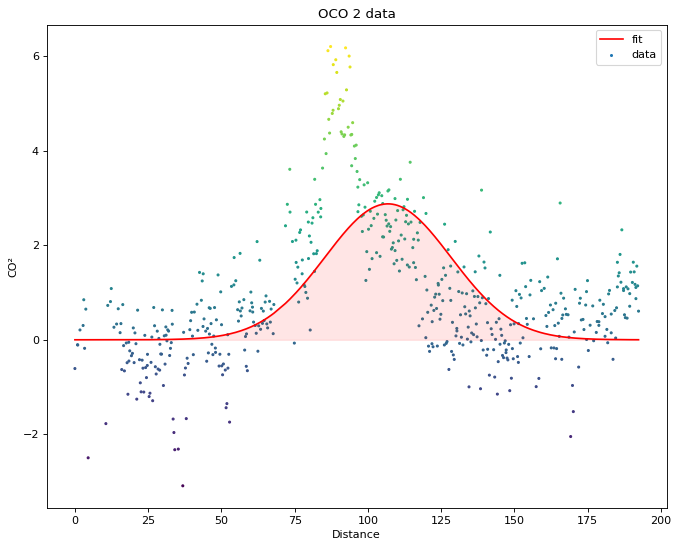

In [0]:
for index in range(len(popt_saved)):
    figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

    x = data_laiwu['distance']
    y = data_laiwu['xco2']

    popt=popt_saved[index]
    print('Best m, b, A, sig = ', popt)
    print("Area under curve", index, ":", round(np.trapz(func(x = x-data_laiwu.loc[soundings[index], 'distance'], m=0, b=0, A=popt[2], sig=popt[3]), x),2))
    m,b,A,sig =popt[0], popt[1], popt[2], popt[3]

    y = y - m * x - b
    plt.scatter(x, y, c=y, s=3, label='data')
    plt.plot(x, func(x = x-data_laiwu.loc[soundings[index], 'distance'], m=0, b=0, A=popt[2], sig=popt[3]), 'r', label='fit')

    plt.fill_between(x, func(x = x-data_laiwu.loc[soundings[index], 'distance'], m=0, b=0, A=popt[2], sig=popt[3]), color=(1,0,0,0.1))

    plt.legend()
    plt.title('OCO 2 data')
    plt.xlabel('Distance')
    plt.ylabel('CO²')
    plt.show()

## ~~Graph E: XCO2 enhancement with Gaussian Plume model~~

In [0]:
data = data_laiwu
data.head(5)

sounding_id   latitude  ...  distance  xco2_enhancement
2069837  2018082505140774  35.429119  ...  0.000000         -1.221359
2069843  2018082505140837  35.436092  ...  0.884612         -0.718735
2069844  2018082505140838  35.426098  ...  0.978853         -0.723923
2069846  2018082505140878  35.444321  ...  1.728416         -0.406021
2069845  2018082505140877  35.454258  ...  2.798695         -0.311813

[5 rows x 11 columns]

In [0]:
def apply_wind(row):
    row['longitude'] = row['longitude'] + row['longitude']*row['windspeed_u']/1000
    row['latitude'] = row['latitude'] + row['latitude']*row['windspeed_v']/1000
    return row

def apply_wind_haversine(row):
    row['longitude'] = haversine_reverse(row['longitude'], 0, )
    
    row['longitude'] + row['longitude']*row['windspeed_u']/1000
    row['latitude'] = row['latitude'] + row['latitude']*row['windspeed_v']/1000
    return row

data = data.apply(lambda row: apply_wind(row), axis=1)
data.head(5)


data_laiwu['distance'] = data_laiwu.apply(lambda row: haversine(row, lat_min, lon_min), axis=1)
data_laiwu

sounding_id   latitude  ...    distance  xco2_enhancement
2069837  2018082505140774  35.429119  ...    0.000000         -1.221359
2069843  2018082505140837  35.436092  ...    0.884612         -0.718735
2069844  2018082505140838  35.426098  ...    0.978853         -0.723923
2069846  2018082505140878  35.444321  ...    1.728416         -0.406021
2069845  2018082505140877  35.454258  ...    2.798695         -0.311813
...                   ...        ...  ...         ...               ...
2070365  2018082505143731  37.088436  ...  191.412622          0.400223
2070400  2018082505143878  37.092781  ...  191.428249          0.163651
2070391  2018082505143836  37.094391  ...  191.738508          0.851700
2070381  2018082505143804  37.095753  ...  192.030838          0.434860
2070372  2018082505143772  37.097023  ...  192.325526         -0.101212

[548 rows x 11 columns]

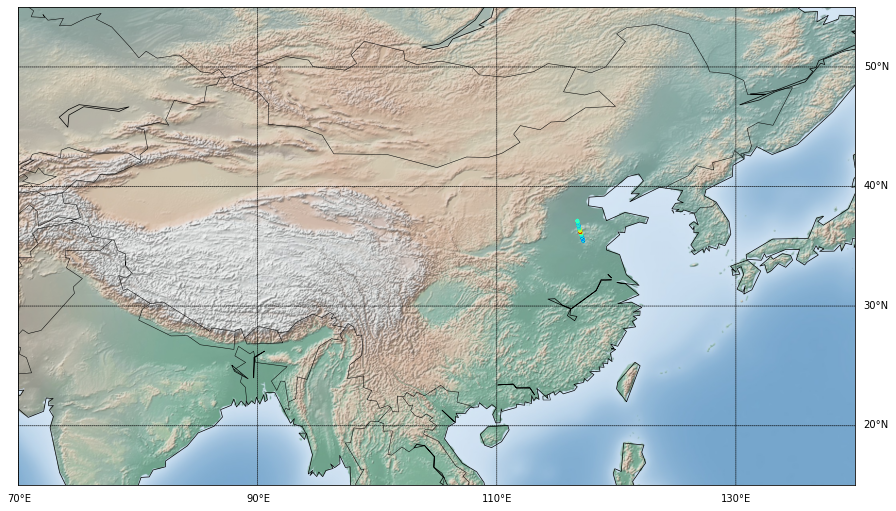

In [0]:
# We retrieve the Figure 2.A with corrected coordinates
draw_map(data, lon_min=70, lon_max=140, lat_min=15, lat_max=55, frontier=True, size_point=5)

In [0]:
data_1808_25_c = data_1808_25.apply(lambda row: apply_wind(row), axis=1)
data_1808_25_c.head(5)

sounding_id   latitude  ...  windspeed_v                    date
2043481  2018082500001474 -22.125867  ...    -5.757070 2018-08-25 00:00:14.740
2043482  2018082500001505 -22.107409  ...    -5.745126 2018-08-25 00:00:15.050
2043483  2018082500001506 -22.107064  ...    -5.737138 2018-08-25 00:00:15.060
2043484  2018082500001535 -22.089215  ...    -5.741576 2018-08-25 00:00:15.350
2043485  2018082500001536 -22.088864  ...    -5.733892 2018-08-25 00:00:15.360

[5 rows x 9 columns]

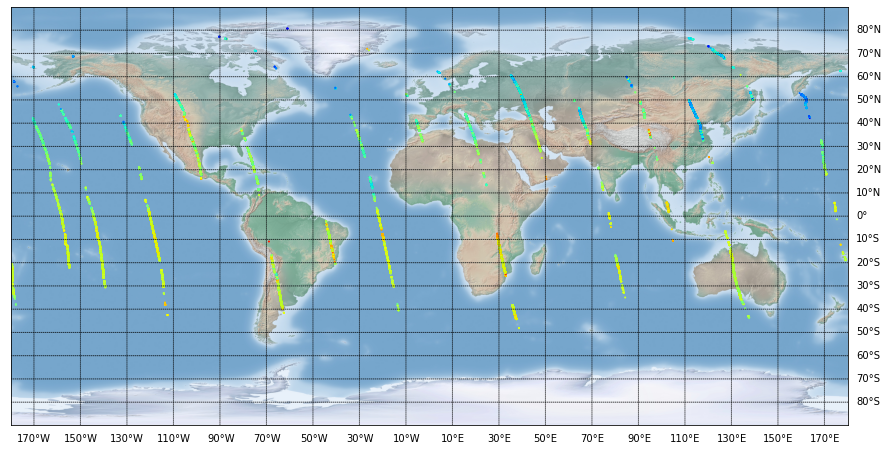

In [0]:
draw_map(data_1808_25_c)

---